In [99]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_breast_cancer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

In [100]:
x, y = load_breast_cancer(return_X_y=True,as_frame=False)
x_df, y_df = load_breast_cancer(return_X_y=True,as_frame=True)
x_df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [101]:
x_train, x_temp, y_train, y_temp = train_test_split(x, y, train_size=0.70, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.50, random_state=42)

In [102]:
x_train.shape


(398, 30)

In [103]:
# 1. Calculate min and max for each column
x_min = np.min(x_train, axis=0)
x_max = np.max(x_train, axis=0)

# 2. Calculate the range (handle potential division by zero)
data_range = x_max - x_min
data_range[data_range == 0] = 1.0  # If a column is all the same value, set range to 1

# 3. Apply the formula
x_train_scaled = (x_train - x_min) / data_range

# Verify the results
print(f"New Min: {np.min(x_train_scaled)}") # Should be 0.0
print(f"New Max: {np.max(x_train_scaled)}") # Should be 1.0

New Min: 0.0
New Max: 1.0


In [116]:
import numpy as np
from typing import List, Tuple, Callable

class Autoencoder:
    def __init__(self,
        input_dim: int,
        encoder_dims: List[int], # hidden encoder layers, atleast 3 layers
        bottleneck_dim: int,
        decoder_dims: List[int], # hidden decoder layers, atleast 3 layers
        activation: str = 'relu', # ('relu', 'sigmoid', 'tanh')
        learning_rate: float = 0.001,
        l2_lambda: float = 0.0001 # L2 regularization parameter. A higher value forces the weights to be smaller.
    ):
        assert len(encoder_dims) >= 3, "Encoder must have at least 3 hidden layers"
        assert len(decoder_dims) >= 3, "Decoder must have at least 3 hidden layers"

        self.input_dim = input_dim
        self.encoder_dims = encoder_dims
        self.bottleneck_dim = bottleneck_dim
        self.decoder_dims = decoder_dims
        self.activation = activation
        self.learning_rate = learning_rate
        self.initial_lr = learning_rate
        self.l2_lambda = l2_lambda

        # Initialize weights and biases
        self.params = {}
        self._initialize_parameters()

        # Cache for storing forward pass values (needed for backprop)
        self.cache = {}

    def _initialize_parameters(self):
        """Initialize weights using He initialization for ReLU, Xavier for others"""
        np.random.seed(42)

        # Encoder weights
        encoder_layers = [self.input_dim] + self.encoder_dims + [self.bottleneck_dim]
        for i in range(len(encoder_layers) - 1):
            # He initialization for ReLU, Xavier for others
            if self.activation == 'relu':
                scale = np.sqrt(2.0 / encoder_layers[i]) # ReLU kills half the neurons (negatives → 0), so we need bigger weights to compensate and keep variance through the layers
            else:
                scale = np.sqrt(1.0 / encoder_layers[i])

            # now set the initial weights of each layer multiplied by the scaling factor
            # scalling factor is important for balanced signals for learning
            self.params[f'W_enc_{i}'] = np.random.randn(
                encoder_layers[i], encoder_layers[i+1]
            ) * scale
            self.params[f'b_enc_{i}'] = np.zeros((1, encoder_layers[i+1]))

        # Decoder weights
        decoder_layers = [self.bottleneck_dim] + self.decoder_dims + [self.input_dim]
        for i in range(len(decoder_layers) - 1):
            if self.activation == 'relu' and i < len(decoder_layers) - 2:
                scale = np.sqrt(2.0 / decoder_layers[i])
            else:
                scale = np.sqrt(1.0 / decoder_layers[i])

            self.params[f'W_dec_{i}'] = np.random.randn(
                decoder_layers[i], decoder_layers[i+1]
            ) * scale
            self.params[f'b_dec_{i}'] = np.zeros((1, decoder_layers[i+1]))

    # ============= Activation Functions =============

    def _relu(self, z):
        return np.maximum(0, z)

    def _relu_derivative(self, z):
        return (z > 0).astype(float)

    def _sigmoid(self, z):
        return 1 / (1 + np.exp(-np.clip(z, -500, 500)))

    def _sigmoid_derivative(self, z):
        s = self._sigmoid(z)
        return s * (1 - s)

    def _tanh(self, z):
        return np.tanh(z)

    def _tanh_derivative(self, z):
        return 1 - np.tanh(z) ** 2

    def _activate(self, z):
        if self.activation == 'relu':
            return self._relu(z)
        elif self.activation == 'sigmoid':
            return self._sigmoid(z)
        elif self.activation == 'tanh':
            return self._tanh(z)

    def _activate_derivative(self, z):
        if self.activation == 'relu':
            return self._relu_derivative(z)
        elif self.activation == 'sigmoid':
            return self._sigmoid_derivative(z)
        elif self.activation == 'tanh':
            return self._tanh_derivative(z)


    def forward(self, X):
        """
        Forward pass through the autoencoder

        Parameters:
        -----------
        X : ndarray of shape (batch_size, input_dim)
            Input data

        Returns:
        --------
        reconstruction : ndarray of shape (batch_size, input_dim)
            Reconstructed data
        """
        self.cache = {}
        self.cache['A_0'] = X

        # Encoder forward pass
        A = X
        num_encoder_layers = len(self.encoder_dims) + 1  # +1 for bottleneck

        for i in range(num_encoder_layers):
            W = self.params[f'W_enc_{i}']
            b = self.params[f'b_enc_{i}']

            Z = np.dot(A, W) + b
            self.cache[f'Z_enc_{i}'] = Z

            # Apply activation (for all encoder layers including bottleneck)
            A = self._activate(Z)
            self.cache[f'A_enc_{i}'] = A

        # Bottleneck is the last encoder activation
        self.cache['bottleneck'] = A

        # Decoder forward pass
        num_decoder_layers = len(self.decoder_dims) + 1  # +1 for output

        for i in range(num_decoder_layers):
            W = self.params[f'W_dec_{i}']
            b = self.params[f'b_dec_{i}']

            Z = np.dot(A, W) + b
            self.cache[f'Z_dec_{i}'] = Z

            # Apply activation for hidden layers, sigmoid for output layer
            if i < num_decoder_layers - 1:
                A = self._activate(Z)
            else:
                # Output layer - use sigmoid to bound output to [0, 1]
                A = self._sigmoid(Z)

            self.cache[f'A_dec_{i}'] = A

        return A

    # ============= Loss Function =============

    def compute_loss(self, X, X_reconstructed):
        """
        Compute Mean Squared Error loss with L2 regularization

        Parameters:
        -----------
        X : ndarray of shape (batch_size, input_dim)
            Original input
        X_reconstructed : ndarray of shape (batch_size, input_dim)
            Reconstructed output

        Returns:
        --------
        loss : float
            Total loss (MSE + L2 regularization)
        """
        m = X.shape[0]

        # Mean Squared Error
        mse_loss = np.mean((X - X_reconstructed) ** 2)

        # L2 Regularization
        l2_loss = 0
        for key in self.params:
            if key.startswith('W_'):
                l2_loss += np.sum(self.params[key] ** 2)

        l2_loss = (self.l2_lambda / (2 * m)) * l2_loss

        return mse_loss + l2_loss
    def evaluate_mse(self, X):
      """
      Returns only the Mean Squared Error (no L2 penalty)
      """
      # 1. Get the reconstruction
      X_reconstructed = self.reconstruct(X)

      # 2. Calculate MSE: Average of (Actual - Predicted)^2
      mse = np.mean((X - X_reconstructed) ** 2)

      return mse

    # ============= Backpropagation =============

    def backward(self, X, X_reconstructed):
        """
        Backward pass - compute gradients using backpropagation

        Parameters:
        -----------
        X : ndarray of shape (batch_size, input_dim)
            Original input
        X_reconstructed : ndarray of shape (batch_size, input_dim)
            Reconstructed output

        Returns:
        --------
        gradients : dict
            Dictionary containing gradients for all parameters
        """
        m = X.shape[0]
        gradients = {}

        # ===== DECODER BACKPROPAGATION =====

        # Output layer gradient (derivative of MSE loss)
        # Loss = (1/m) * sum((y_pred - y_true)^2)
        # dL/dy_pred = (2/m) * (y_pred - y_true)
        dA = (2 / m) * (X_reconstructed - X)

        num_decoder_layers = len(self.decoder_dims) + 1

        for i in range(num_decoder_layers - 1, -1, -1):
            # Get cached values
            Z = self.cache[f'Z_dec_{i}']

            if i > 0:
                A_prev = self.cache[f'A_dec_{i-1}']
            else:
                # First decoder layer uses bottleneck as input
                A_prev = self.cache['bottleneck']

            # Apply activation derivative
            if i == num_decoder_layers - 1:
                # Output layer uses sigmoid
                dZ = dA * self._sigmoid_derivative(Z)
            else:
                dZ = dA * self._activate_derivative(Z)

            # Compute gradients
            W = self.params[f'W_dec_{i}']

            gradients[f'W_dec_{i}'] = np.dot(A_prev.T, dZ) + (self.l2_lambda / m) * W
            gradients[f'b_dec_{i}'] = np.sum(dZ, axis=0, keepdims=True)

            # Propagate gradient to previous layer
            dA = np.dot(dZ, W.T)

        # ===== ENCODER BACKPROPAGATION =====

        # dA now contains gradient flowing into bottleneck
        num_encoder_layers = len(self.encoder_dims) + 1

        for i in range(num_encoder_layers - 1, -1, -1):
            # Get cached values
            Z = self.cache[f'Z_enc_{i}']

            if i > 0:
                A_prev = self.cache[f'A_enc_{i-1}']
            else:
                # First encoder layer uses input
                A_prev = self.cache['A_0']

            # Apply activation derivative
            dZ = dA * self._activate_derivative(Z)

            # Compute gradients
            W = self.params[f'W_enc_{i}']

            gradients[f'W_enc_{i}'] = np.dot(A_prev.T, dZ) + (self.l2_lambda / m) * W
            gradients[f'b_enc_{i}'] = np.sum(dZ, axis=0, keepdims=True)

            # Propagate gradient to previous layer
            dA = np.dot(dZ, W.T)

        return gradients

    # ============= Parameter Updates =============

    def update_parameters(self, gradients):
        """Update parameters using computed gradients"""
        for key in self.params:
            self.params[key] -= self.learning_rate * gradients[key]  # Wnew ​= Wold ​− ( lambda × ∇L )

    # ============= Learning Rate Scheduling =============

    def update_learning_rate(self, epoch, schedule='step'):
        """
        Update learning rate based on schedule
        Its job is to decrease the learning rate as training progresses to prevent overshooting.
        Parameters:
        -----------
        epoch : int
            Current epoch number
        schedule : str
            Type of schedule ('step', 'exponential', 'cosine')
        """
        if schedule == 'step':
            # Reduce LR by factor of 10 every 50 epochs
            if epoch > 0 and epoch % 50 == 0:
                self.learning_rate *= 0.1

        elif schedule == 'exponential':
            # Exponential decay: lr = initial_lr * exp(-decay_rate * epoch)
            decay_rate = 0.01
            self.learning_rate = self.initial_lr * np.exp(-decay_rate * epoch)

        elif schedule == 'cosine':
            # Cosine annealing
            min_lr = self.initial_lr * 0.01
            max_epochs = 100
            self.learning_rate = min_lr + 0.5 * (self.initial_lr - min_lr) * (
                1 + np.cos(np.pi * epoch / max_epochs)
            )

    # ============= Training =============

    def fit(self,
        X_train,
        epochs=100,
        batch_size=32,
        lr_schedule='step',
        verbose=True
    ):
        """
        Train the autoencoder using mini-batch gradient descent

        Parameters:
        -----------
        X_train : ndarray of shape (n_samples, input_dim)
            Training data
        epochs : int
            Number of training epochs
        batch_size : int
            Size of mini-batches
        lr_schedule : str
            Learning rate schedule type
        verbose : bool
            Whether to print training progress

        Returns:
        --------
        history : dict
            Dictionary containing training history (losses)
        """
        n_samples = X_train.shape[0]
        history = {'total_loss': [],
                   'mse_loss': []}

        for epoch in range(epochs):
            # Shuffle data to avoid overfitting
            indices = np.random.permutation(n_samples)
            X_shuffled = X_train[indices]

            epoch_total_losses = []
            epoch_mse_only = []

            # Mini-batch gradient descent
            for i in range(0, n_samples, batch_size):
                X_batch = X_shuffled[i:i+batch_size]

                # Forward pass
                X_reconstructed = self.forward(X_batch)

                # Calculate Pure MSE for reporting
                pure_mse = np.mean((X_batch - X_reconstructed) ** 2)
                epoch_mse_only.append(pure_mse)

                # Compute Total Loss for backprop (MSE + L2)
                loss = self.compute_loss(X_batch, X_reconstructed)
                epoch_total_losses.append(loss)

                # Backward pass
                gradients = self.backward(X_batch, X_reconstructed)

                # Update parameters
                self.update_parameters(gradients)

            # Average loss for epoch
            avg_loss = np.mean(epoch_total_losses)
            avg_mse = np.mean(epoch_mse_only)
            history['total_loss'].append(avg_loss)
            history['mse_loss'].append(avg_mse)

            # Update learning rate
            self.update_learning_rate(epoch, schedule=lr_schedule)

            # Print progress
            if verbose and (epoch % 10 == 0 or epoch == epochs - 1):
                print(f"Epoch {epoch} - Total Loss: {avg_loss:.4f} - Reconstruction MSE: {avg_mse:.6f}")

        if verbose:

          # Set the figure size for better visibility

          plt.figure(figsize=(6, 4))

          # Plot both lines
          plt.plot(history['mse_loss'], label='Reconstruction MSE', color='blue', linewidth=2)
          plt.plot(history['total_loss'], label='Total Loss (MSE + L2)', color='orange', linestyle='--')

          # Add details
          plt.title('Training Progress: Total Loss vs. Reconstruction Error')
          plt.xlabel('Epochs')
          plt.ylabel('Loss Value')
          plt.grid(True, linestyle=':', alpha=0.6) # Adds a subtle grid for easier reading
          plt.legend() # This is the "magic" line that shows the labels

          plt.show()

        return history

    # ============= Utility Methods =============

    def encode(self, X):
        """Encode input to bottleneck representation"""
        self.forward(X)
        return self.cache['bottleneck']

    def decode(self, Z):
        """Decode bottleneck representation to output"""
        A = Z
        num_decoder_layers = len(self.decoder_dims) + 1

        for i in range(num_decoder_layers):
            W = self.params[f'W_dec_{i}']
            b = self.params[f'b_dec_{i}']
            Z_dec = np.dot(A, W) + b

            if i < num_decoder_layers - 1:
                A = self._activate(Z_dec)
            else:
                A = self._sigmoid(Z_dec)

        return A

    def reconstruct(self, X):
        """Full reconstruction: encode then decode"""
        return self.forward(X)

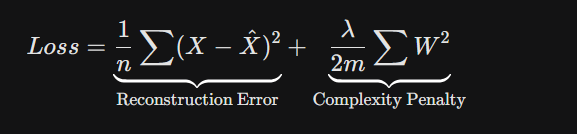

Epoch 0 - Total Loss: 0.1555 - Reconstruction MSE: 0.092548
Epoch 10 - Total Loss: 0.0867 - Reconstruction MSE: 0.023354
Epoch 20 - Total Loss: 0.0796 - Reconstruction MSE: 0.016162
Epoch 30 - Total Loss: 0.0786 - Reconstruction MSE: 0.015259
Epoch 40 - Total Loss: 0.0783 - Reconstruction MSE: 0.014918
Epoch 50 - Total Loss: 0.0776 - Reconstruction MSE: 0.014266
Epoch 60 - Total Loss: 0.0773 - Reconstruction MSE: 0.013998
Epoch 70 - Total Loss: 0.0772 - Reconstruction MSE: 0.013948
Epoch 80 - Total Loss: 0.0773 - Reconstruction MSE: 0.013984
Epoch 90 - Total Loss: 0.0770 - Reconstruction MSE: 0.013693
Epoch 99 - Total Loss: 0.0772 - Reconstruction MSE: 0.013938


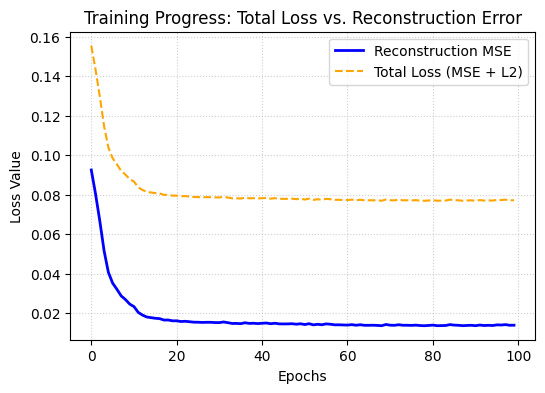

In [105]:
# 1. Initialize
model = Autoencoder(
    input_dim=x_train.shape[1],
    encoder_dims=[30, 28, 24], # 3 hidden layers for encoder
    bottleneck_dim=5,         # The compressed representation
    decoder_dims=[24, 28, 30], # 3 hidden layers for decoder
    activation='relu',
    learning_rate=0.01,
    l2_lambda=0.01
)

# 2. Train (Fit)
history = model.fit(x_train_scaled, epochs=100, batch_size=32, lr_schedule='cosine')

## silhouette_score

In [135]:
def euclidean_distance(p1, p2):
        return np.sqrt(np.sum((p1 - p2) ** 2))
def silhouette_score( X, labels):
        """
        Computes the mean Silhouette Coefficient of all samples.
        """
        n_samples = X.shape[0]
        unique_labels = np.unique(labels)

        # If there is only 1 cluster, silhouette score is undefined (usually 0)
        if len(unique_labels) < 2:
            return 0

        scores = []

        for i in range(n_samples):
            # 1. Calculate a(i): Mean distance to others in same cluster
            current_label = labels[i]
            same_cluster_indices = np.where(labels == current_label)[0]
            # Exclude the point itself
            same_cluster_indices = same_cluster_indices[same_cluster_indices != i]

            if len(same_cluster_indices) > 0:
                a_i = np.mean([euclidean_distance(X[i], X[idx]) for idx in same_cluster_indices])
            else:
                a_i = 0 # Single point cluster

            # 2. Calculate b(i): Mean distance to the nearest 'other' cluster
            b_i = float('inf')
            for other_label in unique_labels:
                if other_label == current_label:
                    continue

                other_cluster_indices = np.where(labels == other_label)[0]
                avg_dist_to_other_cluster = np.mean([
                    euclidean_distance(X[i], X[idx]) for idx in other_cluster_indices
                ])
                b_i = min(b_i, avg_dist_to_other_cluster)

            # 3. Calculate s(i)
            s_i = (b_i - a_i) / max(a_i, b_i)
            scores.append(s_i)

        return np.mean(scores)

# Experiments

## diffrent number of bottlneck sizes

In [123]:
bottle_neck_sizes = [ 2, 5, 10, 15, 20]
for i in bottle_neck_sizes:
  print(f"Bottleneck size {i}: ")
  autoencoder = Autoencoder(
    input_dim=x_train.shape[1],
    encoder_dims=[30, 28, 24], # 3 hidden layers for encoder
    bottleneck_dim=i,         # The compressed representation
    decoder_dims=[24, 28, 30], # 3 hidden layers for decoder
    activation='relu',
    learning_rate=0.01,
    l2_lambda=0.01
)
  autoencoder.fit(x_train_scaled, verbose=False)

Bottleneck size 2: 
Bottleneck size 5: 
Bottleneck size 10: 
Bottleneck size 15: 
Bottleneck size 20: 


In [111]:
# Transform the scaled data into the compressed representation
# This moves data from (N, input_dim) -> (N, bottleneck_dim)
X_latent = model.encode(x_train_scaled)
print(f"Shape beofre encoding: {x_train_scaled.shape}")
print(f"Shape after encoding: {X_latent.shape}")

Shape beofre encoding: (398, 30)
Shape after encoding: (398, 5)



Evaluating Bottleneck size 2...
MSE: 0.013800 | Silhouette: 0.6301 | ARI: 0.6128

Evaluating Bottleneck size 5...
MSE: 0.014009 | Silhouette: 0.6531 | ARI: 0.5362

Evaluating Bottleneck size 10...
MSE: 0.011457 | Silhouette: 0.4997 | ARI: 0.7021

Evaluating Bottleneck size 15...
MSE: 0.011264 | Silhouette: 0.4561 | ARI: 0.5558

Evaluating Bottleneck size 20...
MSE: 0.012188 | Silhouette: 0.5427 | ARI: 0.6517


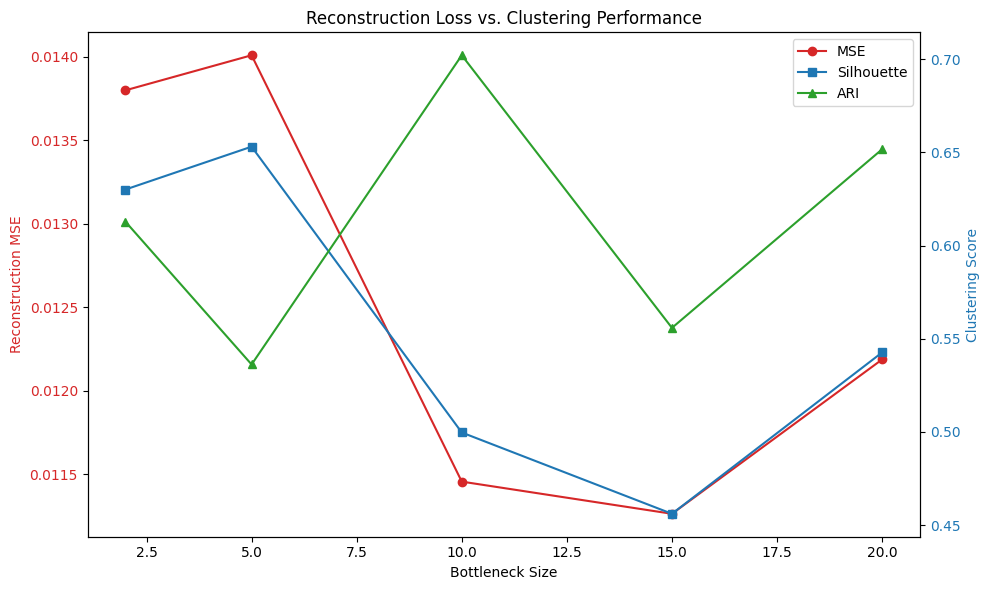

In [136]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
import matplotlib.pyplot as plt

bottle_neck_sizes = [2, 5, 10, 15, 20]
results = {
    'size': [],
    'mse': [],
    'silhouette': [],
    'ari': []
}

for i in bottle_neck_sizes:
    print(f"\nEvaluating Bottleneck size {i}...")

    # 1. Initialize and Train
    autoencoder = Autoencoder(
        input_dim=x_train_scaled.shape[1],
        encoder_dims=[30, 28, 24],
        bottleneck_dim=i,
        decoder_dims=[24, 28, 30],
        activation='relu',
        learning_rate=0.01,
        l2_lambda=0.01
    )
    autoencoder.fit(x_train_scaled, epochs=50, verbose=False)

    # 2. Get Reconstruction Loss (MSE)
    mse = autoencoder.evaluate_mse(x_train_scaled)

    # 3. Get Compressed Features (Bottleneck)
    encoded_features = autoencoder.encode(x_train_scaled)

    # 4. Apply K-Means
    # Assuming 'n_clusters' is the number of classes in your dataset
    n_clusters = len(np.unique(y_train))
    kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=42)
    cluster_labels = kmeans.fit_predict(encoded_features)

    # 5. Calculate Performance Metrics
    sil = silhouette_score(encoded_features, cluster_labels)
    ari = adjusted_rand_score(y_train, cluster_labels)

    # Store results
    results['size'].append(i)
    results['mse'].append(mse)
    results['silhouette'].append(sil)
    results['ari'].append(ari)

    print(f"MSE: {mse:.6f} | Silhouette: {sil:.4f} | ARI: {ari:.4f}")

# --- Visualization ---
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot MSE
color = 'tab:red'
ax1.set_xlabel('Bottleneck Size')
ax1.set_ylabel('Reconstruction MSE', color=color)
ax1.plot(results['size'], results['mse'], marker='o', color=color, label='MSE')
ax1.tick_params(axis='y', labelcolor=color)

# Create a second y-axis for Clustering Scores
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Clustering Score', color=color)
ax2.plot(results['size'], results['silhouette'], marker='s', color=color, label='Silhouette')
ax2.plot(results['size'], results['ari'], marker='^', color='tab:green', label='ARI')
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Reconstruction Loss vs. Clustering Performance')
fig.tight_layout()
fig.legend(loc='upper right', bbox_to_anchor=(1, 1), bbox_transform=ax1.transAxes)
plt.show()

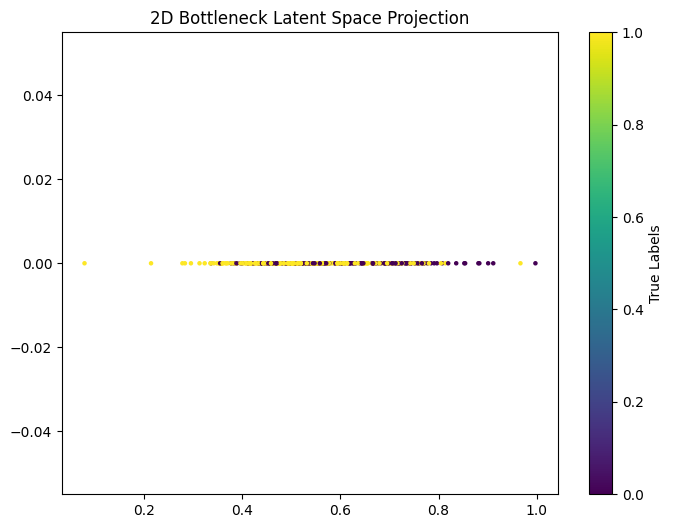

In [126]:
# Use the trained autoencoder for size 2
encoded_2d = autoencoder.encode(x_train_scaled)

plt.figure(figsize=(8, 6))
plt.scatter(encoded_2d[:, 0], encoded_2d[:, 1], c=y_train, cmap='viridis', s=5)
plt.colorbar(label='True Labels')
plt.title("2D Bottleneck Latent Space Projection")
plt.show()